# Setup

### Import libraries

In [267]:
import os
import csv
import cv2     
import shutil 
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Prepare the dataset

In [60]:
data_dir = Path("BiNet_Dataset")
class_names = ['Corrosionstain', 'Cracks', 'Exposedbars', 'Spalling']

# Data Preprocessing

### Splitting the data

In [61]:
def split_data(data_dir, class_names, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Splits the data into training, validation, and testing sets.

    Parameters:
        data_dir: The directory of the data.
        class_names: List of class names.
        train_ratio: The ratio of the data to be used for training.
        val_ratio: The ratio of the data to be used for validation.
        test_ratio: The ratio of the data to be used for testing.
        
        Returns:
        PosixPath: The directory of training files.
        PosixPath: The directory of validation files.
        PosixPath: The directory of testing files.
    """

    # Create directories for training, validation, and testing sets
    train_dir = data_dir / "train/"
    val_dir = data_dir / "val/"
    test_dir = data_dir / "test/"

    # Create directories for each class in the training, validation, and testing folders
    for dir_path in [train_dir, val_dir, test_dir]:
        dir_path.mkdir(exist_ok=True, parents=True)

    # Iterate over each class
    for class_name in class_names:
        all_files = list((data_dir / class_name).glob("*.png"))
        np.random.shuffle(all_files)

        # Calculate the number of files for each set
        train_count = int(len(all_files) * train_ratio)
        val_count = int(len(all_files) * val_ratio)

        # Split the data into training, validation, and testing sets
        train_files = all_files[:train_count]
        val_files = all_files[train_count:train_count + val_count]
        test_files = all_files[train_count + val_count:]

        # Copy the files to the appropriate directories
        for subset, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
            subset_class_dir = subset / class_name
            subset_class_dir.mkdir(exist_ok=True)
            for file in files:
                shutil.copy(file, subset_class_dir) 
    
    return train_dir, val_dir, test_dir      

In [62]:
train_dir, val_dir, test_dir = split_data(data_dir, class_names)

### Loading the data

In [63]:
def create_csv(dataset, class_names):
    """
    Creates a CSV file from the dataset and returns the path to the CSV file.

    Parameters:
        dataset: The directory of the dataset.
        class_names: List of class names.

    Returns:
        str: The path to the created CSV file.
    """
    
    data = []
    
    print("Loading {}".format(dataset))

    # Iterate through each folder
    for label in class_names:
        folder = label
        
        # Iterate through each image in our folder
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
            
            # Get the path name of the image
            img_path = os.path.join(dataset, folder, file)
            
            # Open the image and get its size
            image = cv2.imread(img_path)
            if image is not None:
                height, width, _ = image.shape
                size = f"{width}x{height}"
                
                # Append the image name, label, and size to the data list
                data.append([img_path, label, size])

    # Define the CSV file name
    csv_file_name = f"df_{os.path.basename(dataset)}.csv"
    
    # Open the file in write mode
    with open(csv_file_name, mode='w', newline='') as file:
        # Create a csv.writer object
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Image Path', 'Label', 'Image Size'])
        
        # Write data to the CSV file
        writer.writerows(data)
    
    print(f"CSV file saved to {csv_file_name}")
    
    return csv_file_name

### Create csv files from the datasets

In [64]:
csv_train = create_csv(train_dir, class_names)
csv_val = create_csv(val_dir, class_names)
csv_test = create_csv(test_dir, class_names)

Loading BiNet_Dataset/train


100%|██████████| 168/168 [00:00<00:00, 207.28it/s]


CSV file saved to df_train.csv
Loading BiNet_Dataset/val


100%|██████████| 24/24 [00:00<00:00, 186.35it/s]


CSV file saved to df_val.csv
Loading BiNet_Dataset/test


100%|██████████| 48/48 [00:00<00:00, 205.51it/s]

CSV file saved to df_test.csv


### Create DataFrames from the csv files

In [ ]:
df_train = pd.read_csv(csv_train)
df_val = pd.read_csv(csv_val)
df_test = pd.read_csv(csv_test)

# Combine the 3 DataFrames
combined_df = pd.concat([df_train, df_val, df_test])

### Data Exploration

##### Check the split ratio of the dataset

In [248]:
# Count the total number of images in each dataframe
train_count = len(df_train)
val_count = len(df_val)
test_count = len(df_test)

# Create a DataFrame to store the counts
data_counts = pd.DataFrame({
    'DataFrame': ['Train', 'Validation', 'Test'],
    'Images': [train_count, val_count, test_count]
})

fig_pie = px.pie(data_counts, 
                 names='DataFrame', 
                 values='Images', 
                 title='Split ratio of the dataset')

fig_pie.show()

The dataset seems to be properly distributed.

##### Check the class distribution

In [204]:
# Count the occurrences of each label in each DataFrame
train_counts = df_train['Label'].value_counts()
val_counts = df_val['Label'].value_counts()
test_counts = df_test['Label'].value_counts()

# Create a DataFrame to hold the counts
label_counts_df = pd.DataFrame({
    'Label': train_counts.index,
    'Train': train_counts.values,
    'Validation': val_counts.values,
    'Test': test_counts.values
})

# Melt the DataFrame for plotly
label_counts_melted = label_counts_df.melt(id_vars='Label', var_name='DataFrame', value_name='Count')

label_x = 'Damage class'
label_y = 'No. of images'

fig = px.bar(label_counts_melted, 
             height=600,
             x='Label', 
             y='Count', 
             color='DataFrame', 
             barmode='group', 
             title='Damage class distribution across datasets',
             labels={'Label': label_x, 'Count': label_y},
             text='Count')  

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_tickangle=0)

fig.show()

In [234]:
# Count the occurrences of each label
label_distribution = combined_df['Label'].value_counts()

# Create a DataFrame for the pie chart
label_distribution_df = pd.DataFrame(label_distribution).reset_index()
label_distribution_df.columns = ['Label', 'Images']

fig = px.pie(label_distribution_df, 
             names='Label', 
             values='Images', 
             title='Damage class percent distribution'
             ) 

fig.show()

Class imbalance is present. The imbalance will be addressed using weighted sampling.

##### Check image size variety

In [249]:
img_size_df = pd.DataFrame(columns=['Width', 'Height'])
img_size_df[['Width', 'Height']] = combined_df['Image Size'].str.split('x', expand=True)

img_size_df["Width"] = pd.to_numeric(img_size_df["Width"])
img_size_df["Height"] = pd.to_numeric(img_size_df["Height"])

xlabel = 'Width (pixels)'
ylabel = 'Height (pixels)'
fig = px.scatter(img_size_df, x='Width', y='Height',
                 height=600,
                 title='Image Size variety',
                 labels={'Width': xlabel, 'Height': ylabel})

fig.show()

img_size_df.describe()

,Width,Height
count,3471.000000,3471.000000
mean,444.431000,438.699798
std,403.524937,388.013361
min,26.000000,32.000000
25%,179.000000,162.000000
50%,308.000000,314.000000
75%,562.500000,611.000000
max,3918.000000,3983.000000


The images vary in sizes, but most images seem to be at around 200x200 pixels.

### Create Generators

In [263]:
# data augmentation for training set
train_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='float32'
)

# scaler for validation and test sets
val_test_gen = ImageDataGenerator(
    rescale=1.0/255,
    dtype='float32'  
)

In [264]:
IMG_WIDTH = IMG_HEIGHT = 224
BATCH_SIZE = 64

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2428 images belonging to 4 classes.
Found 347 images belonging to 4 classes.
Found 696 images belonging to 4 classes.


### Add Class Weights

Declare class weights to address the class imbalance

In [270]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

pd.DataFrame(list(class_weights.items()), columns=['Class', 'Weight'])

,Class,Weight
0,0,0.903274
1,1,0.652688
2,2,0.922492
3,3,3.613095


### Check generator images

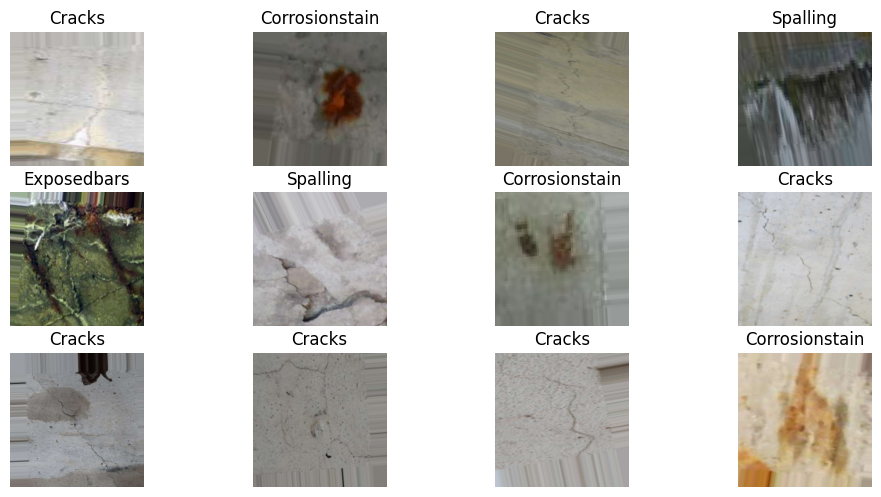

In [272]:
def plot_sample_images(generator, class_labels):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

class_labels = list(train_generator.class_indices.keys())
plot_sample_images(train_generator, class_labels)

# Model

### Model evaluation plot

In [273]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

### Model creation

In [279]:
model_uno = models.Sequential()
model_uno.add(layers.InputLayer(shape=(IMG_WIDTH, IMG_HEIGHT, 3))) 

model_uno.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_uno.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_uno.add(layers.Flatten())

model_uno.add(layers.Dense(128, activation='relu'))
model_uno.add(layers.Dense(len(class_names), activation='softmax'))  

model_uno.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_uno.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    50,466,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,468,356 (192.52 MB)

 Trainable params: 50,468,356 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

### Model fitting

In [280]:
history = model_uno.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Set the number of epochs as needed
    steps_per_epoch=len(train_generator),  # Total number of batches in the training set
    validation_steps=len(val_generator),  # Total number of batches in the validation set
)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10


I0000 00:00:1734094005.495080  154418 service.cc:148] XLA service 0x7f1e98004e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734094005.495597  154418 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-13 20:46:45.546916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734094005.692003  154418 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/38 ━━━━━━━━━━━━━━━━━━━━ 3:18 5s/step - accuracy: 0.2188 - loss: 1.4115

I0000 00:00:1734094009.042325  154418 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 661ms/step - accuracy: 0.3265 - loss: 18.7640 - val_accuracy: 0.5389 - val_loss: 1.0582
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - accuracy: 0.5251 - loss: 1.1434 - val_accuracy: 0.6282 - val_loss: 0.9949
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.6124 - loss: 1.0284 - val_accuracy: 0.7032 - val_loss: 0.8928
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.6190 - loss: 1.0035 - val_accuracy: 0.6945 - val_loss: 0.9175
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 634ms/step - accuracy: 0.6514 - loss: 0.9594 - val_accuracy: 0.7406 - val_loss: 0.8016
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 554ms/step - accuracy: 0.6756 - loss: 0.9178 - val_accuracy: 0.7320 - val_loss: 0.7707
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 564ms/step - accuracy: 0.6723 - loss: 0.9243 - val_accuracy: 0.7032 - val_loss: 0.8047
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.6717 - loss: 0.8848 - val_accuracy: 0.72

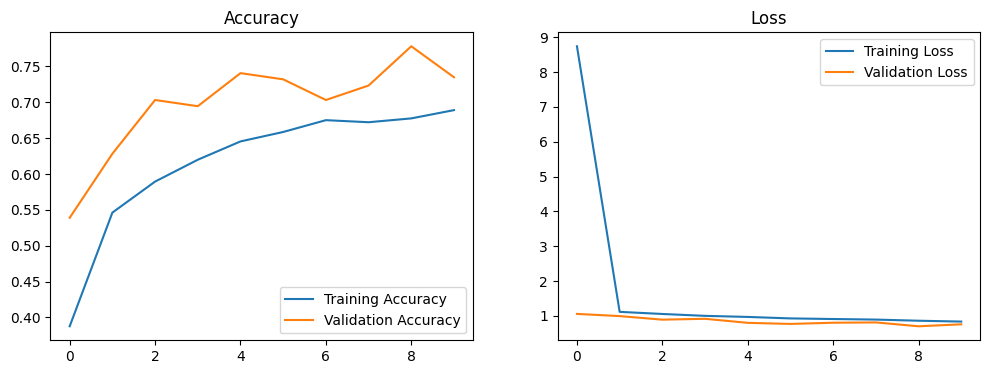

In [281]:
plot_training_history(history)